In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.special import logsumexp
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sns.set_style("whitegrid")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_palette("muted")    # Options: deep, muted, bright, pastel, dark, colorblind

In [3]:
data_set = "DS5" # dataset to plot

models = ["VBPI_10","VBPI_20","reinforce","reparam","VIMCO"]

colors = {"BEAST":plt.cm.tab10(0),
          "VBPI_10":plt.cm.tab10(1),
          "VBPI_20":plt.cm.tab10(2),
          "reinforce":plt.cm.tab10(3),
          "reparam":plt.cm.tab10(4),
          "VIMCO":plt.cm.tab10(5)}

linestyles = {"BEAST":"-",
              "VBPI_10":"--",
              "VBPI_20":"-.",
              "reinforce":":",
              "reparam":"--",
              "VIMCO":"-."}

# Plot:
 - time / likelihood evaluation vs number of taxa
 - time / likelihood evaluation vs number of sites

In [5]:
with open('../results/sec_per_iter.pickle', 'rb') as f:
    sec_per_iter = pickle.load(f)

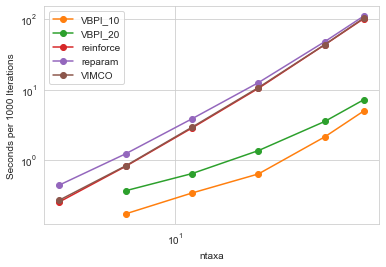

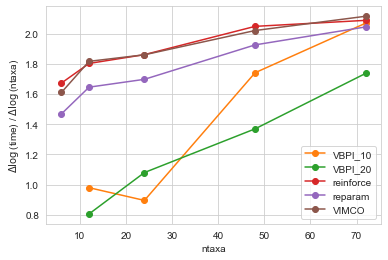

In [6]:
datasets = ["DS14_3","DS14_6","DS14_12","DS14_24","DS14_48","DS14_72"]
ntaxa = [3,6,12,24,48,72]

for model in models:
    plt.plot(ntaxa,
             [100*sec_per_iter[model][x] for x in datasets],
             color = colors[model], marker = "o")

plt.ylabel("Seconds per 1000 Iterations")
plt.xlabel("ntaxa")
plt.legend(models)
plt.yscale("log")
plt.xscale("log")
plt.savefig("../plt/sec_v_ntaxa.png", dpi = 600)
plt.show()

###

def dlogy_dlogx(y,x):
    return [(np.log(y[i+1])-np.log(y[i])) / (np.log(x[i+1])-np.log(x[i])) for i in range(len(y)-1)]

for model in models:
    plt.plot(ntaxa[1:],
                dlogy_dlogx(list(sec_per_iter[model].values()),ntaxa),
                color = colors[model], marker = "o")

plt.ylabel(r"$\Delta \log$(time) / $\Delta \log$(ntaxa)")
plt.xlabel("ntaxa")
plt.legend(models)
plt.savefig("../plt/dydx_v_ntaxa.png", dpi = 600)
plt.show()

# Plot by Dataset

In [9]:
with open('../results/'+data_set+'/iters.pickle', 'rb') as handle:
    iters = pickle.load(handle)

with open('../results/'+data_set+'/runtimes.pickle', 'rb') as handle:
    runtimes = pickle.load(handle)

with open('../results/'+data_set+'/MLLs.pickle', 'rb') as handle:
    MLLs = pickle.load(handle)

with open('../results/'+data_set+'/tree_lengths.pickle', 'rb') as handle:
    tree_lengths = pickle.load(handle)
    
with open('../results/'+data_set+'/root_heights.pickle', 'rb') as handle:
    root_heights = pickle.load(handle)
    
with open('../results/'+data_set+'/log_likes.pickle', 'rb') as handle:
    log_likes = pickle.load(handle)
    
with open('../results/'+data_set+'/log_priors.pickle', 'rb') as handle:
    log_priors = pickle.load(handle)
    
with open('../results/'+data_set+'/log_p_minus_log_q.pickle', 'rb') as handle:
    log_p_minus_log_q = pickle.load(handle)
    
with open('../results/'+data_set+'/BEAST_MLLs.pickle', 'rb') as handle:
    BEAST_MLLs = pickle.load(handle)

# Recreate Figure 9 from Zhang et al (2024)

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_2166/3084457878.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


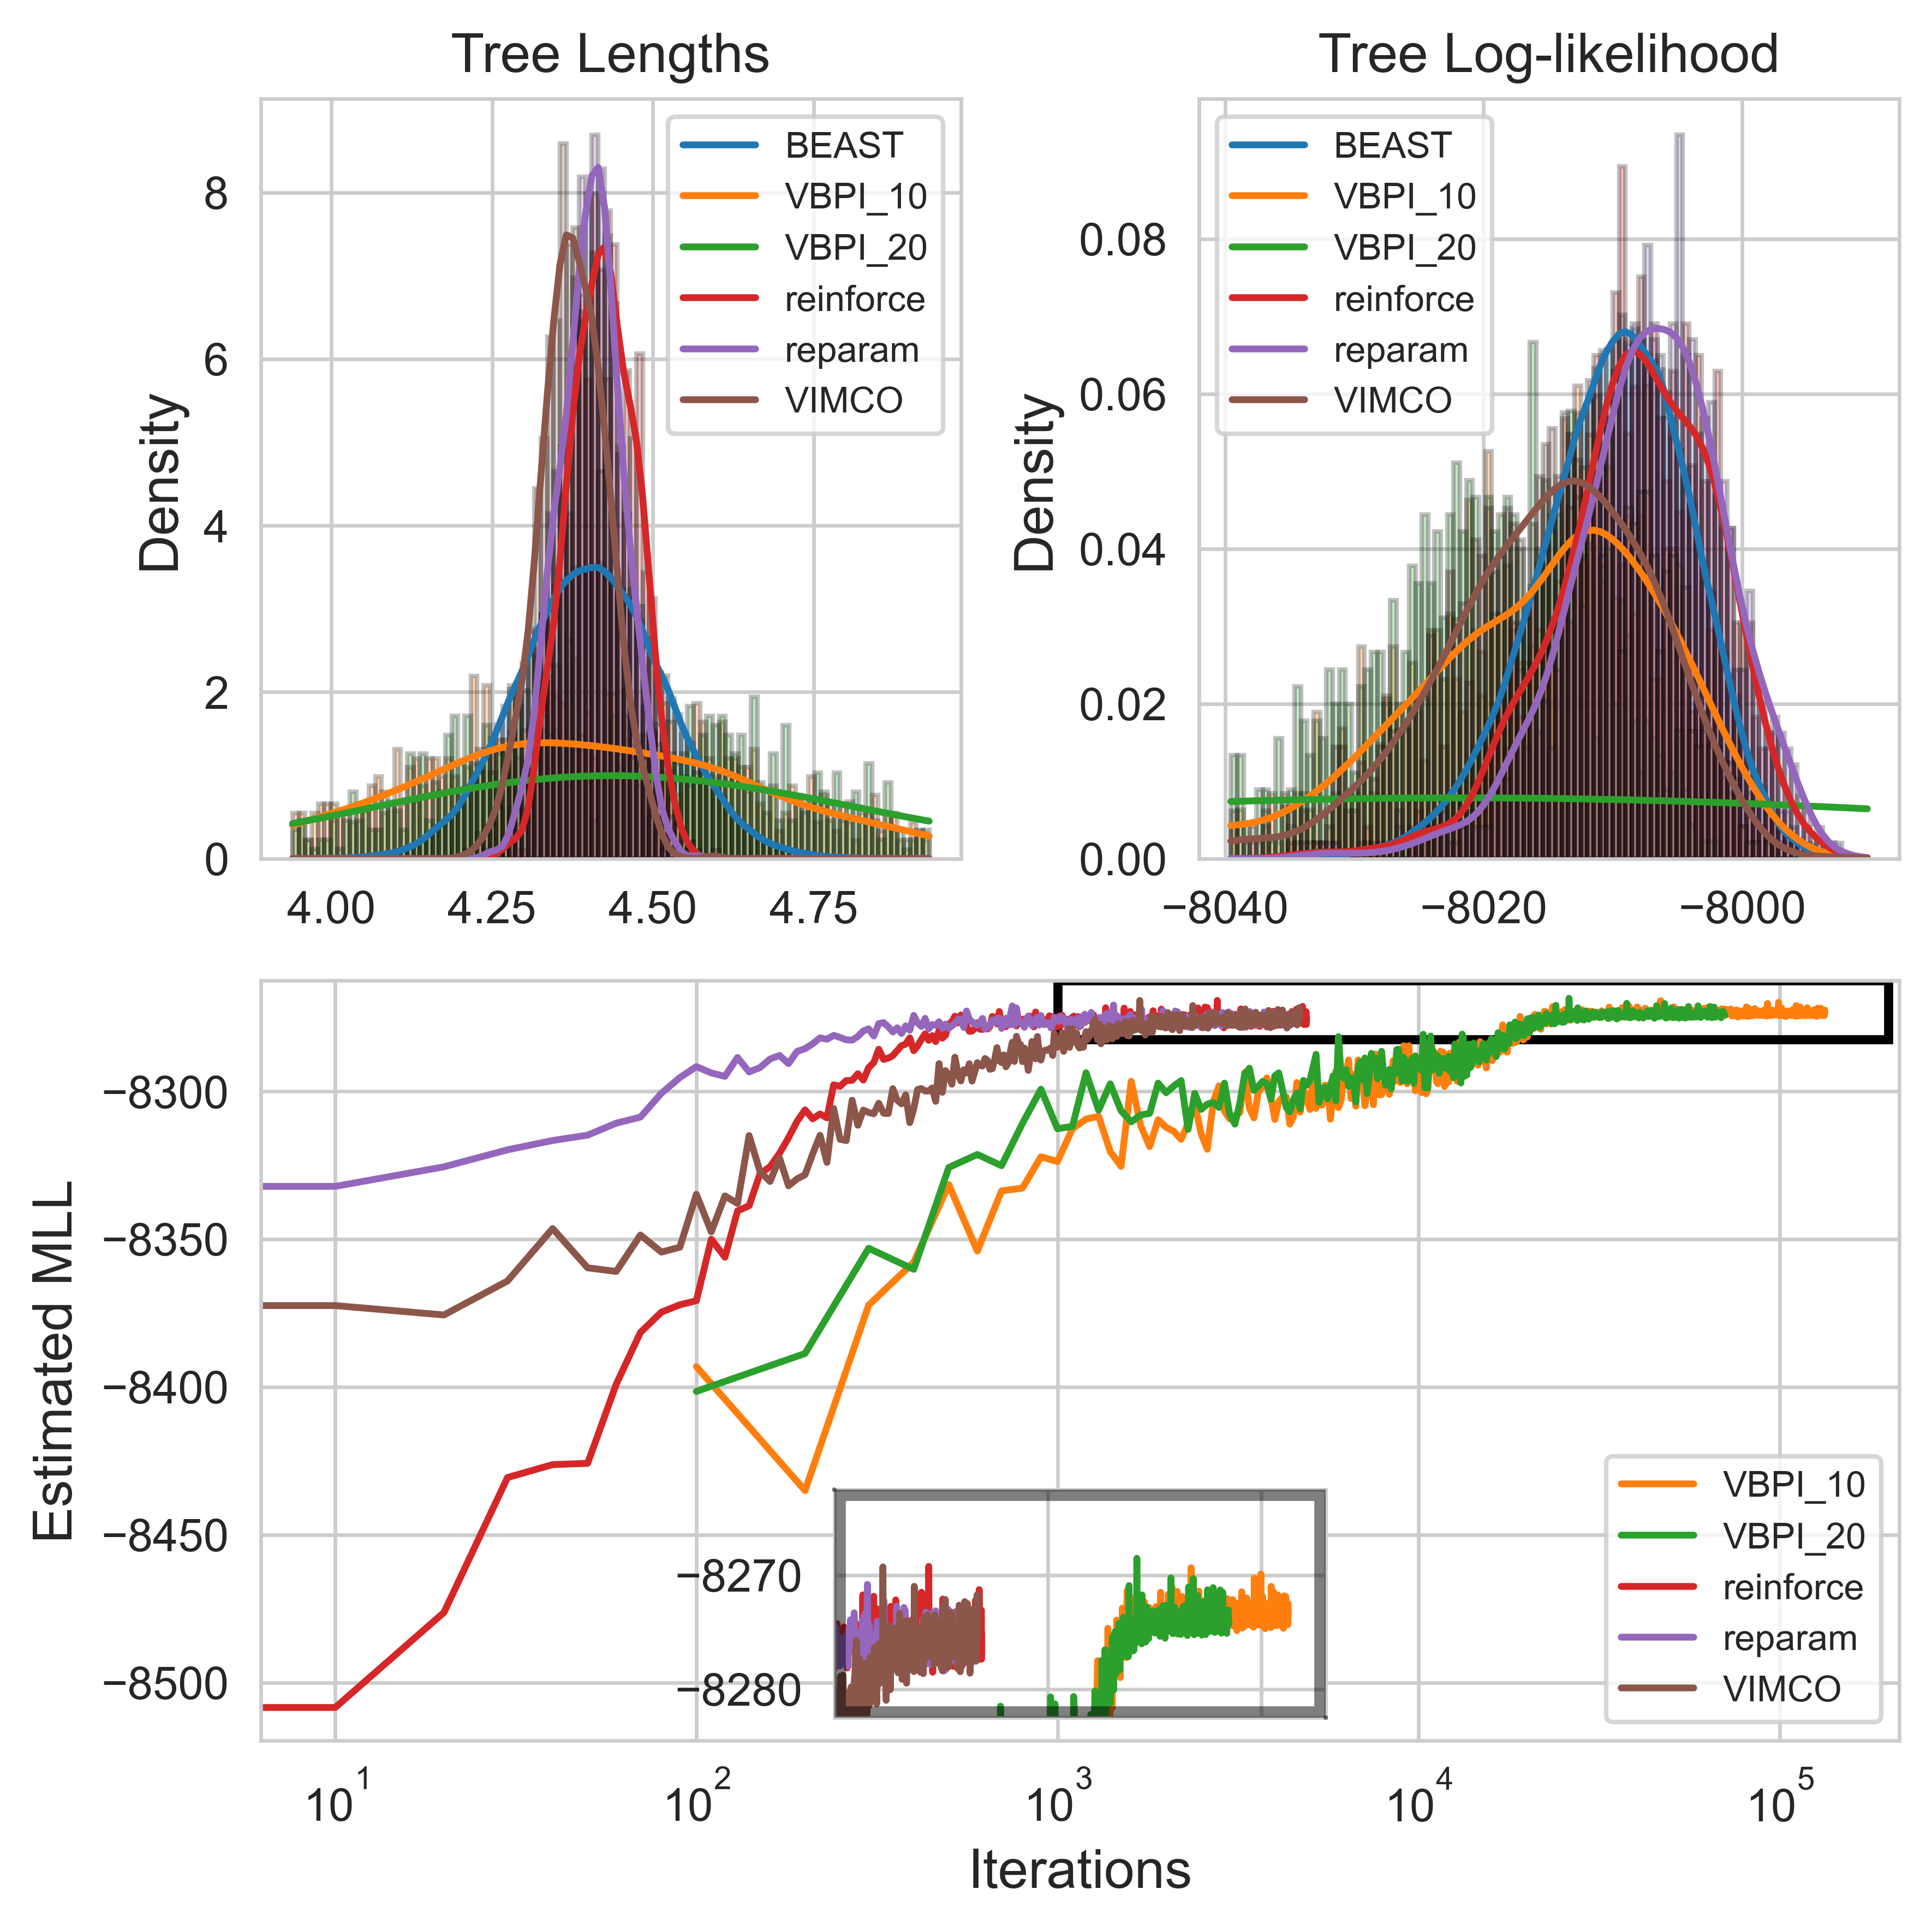

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi = 600)

### ELBO over time ###

plt.subplot(2,1,2)

for model in models:
    plt.plot(iters[model],
             MLLs[model],
             color = colors[model])

ELBO_max = max([MLLs[model][-1] for model in MLLs])
ELBO_min = min([min(MLLs[model]) for model in ["reparam","reinforce","VIMCO"]])

plt.ylim(ELBO_min-5,ELBO_max+10)
plt.ylabel("Estimated MLL",fontsize = 12)

plt.xscale('log')
plt.xlabel("Iterations",fontsize = 12)

plt.legend(models,prop={'size': 8})


# Define the inset
zoom_region = (1000, 200000)  # Specify the region to zoom in
plt.gca().add_patch(plt.Rectangle((zoom_region[0], ELBO_max-10), zoom_region[1] - zoom_region[0], 20,
                                   edgecolor="black", facecolor="none", lw=2))
axins = inset_axes(plt.gca(), width="30%", height="30%", loc="lower center")

for model in models:
    axins.plot(iters[model],
               MLLs[model],
               color = colors[model])

# Set inset limits and labels
axins.set_xlim(zoom_region)
axins.set_xscale('log')
axins.set_xticklabels([])
axins.set_ylim([ELBO_max-10,ELBO_max+10])


# Add a rectangle to indicate the zoomed region
plt.gca().indicate_inset_zoom(axins, edgecolor="black", lw=5)


### Tree lengths ###

def plot_histogram(data,title):
    _, bins, _ = plt.hist(data["BEAST"], bins = 100, edgecolor='black', alpha = 0.25, 
                      density=True, color=colors["BEAST"])
    density = gaussian_kde(data["BEAST"])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle='-', color=colors["BEAST"])

    for model in models:
        plt.hist(data[model], bins = bins, edgecolor='black', alpha = 0.25, 
                 density=True, color=colors[model])
        density = gaussian_kde(data[model])
        density_vals = density(bins)
        plt.plot(bins, density_vals, linestyle='-', color=colors[model])

    plt.legend(["BEAST"]+models,prop={'size': 8})
    plt.title(title)
    plt.ylabel("Density",fontsize = 12)

    return


plt.subplot(2,2,1)
data = {k: tree_lengths[k] for k in ["BEAST"]+models}
title = "Tree Lengths"
plot_histogram(data,title)

plt.subplot(2,2,2)
data = {k: log_likes[k] for k in ["BEAST"]+models}
title = "Tree Log-likelihood"
plot_histogram(data,title)

plt.tight_layout()
plt.savefig('../plt/'+data_set+'/hist.png')
plt.show()

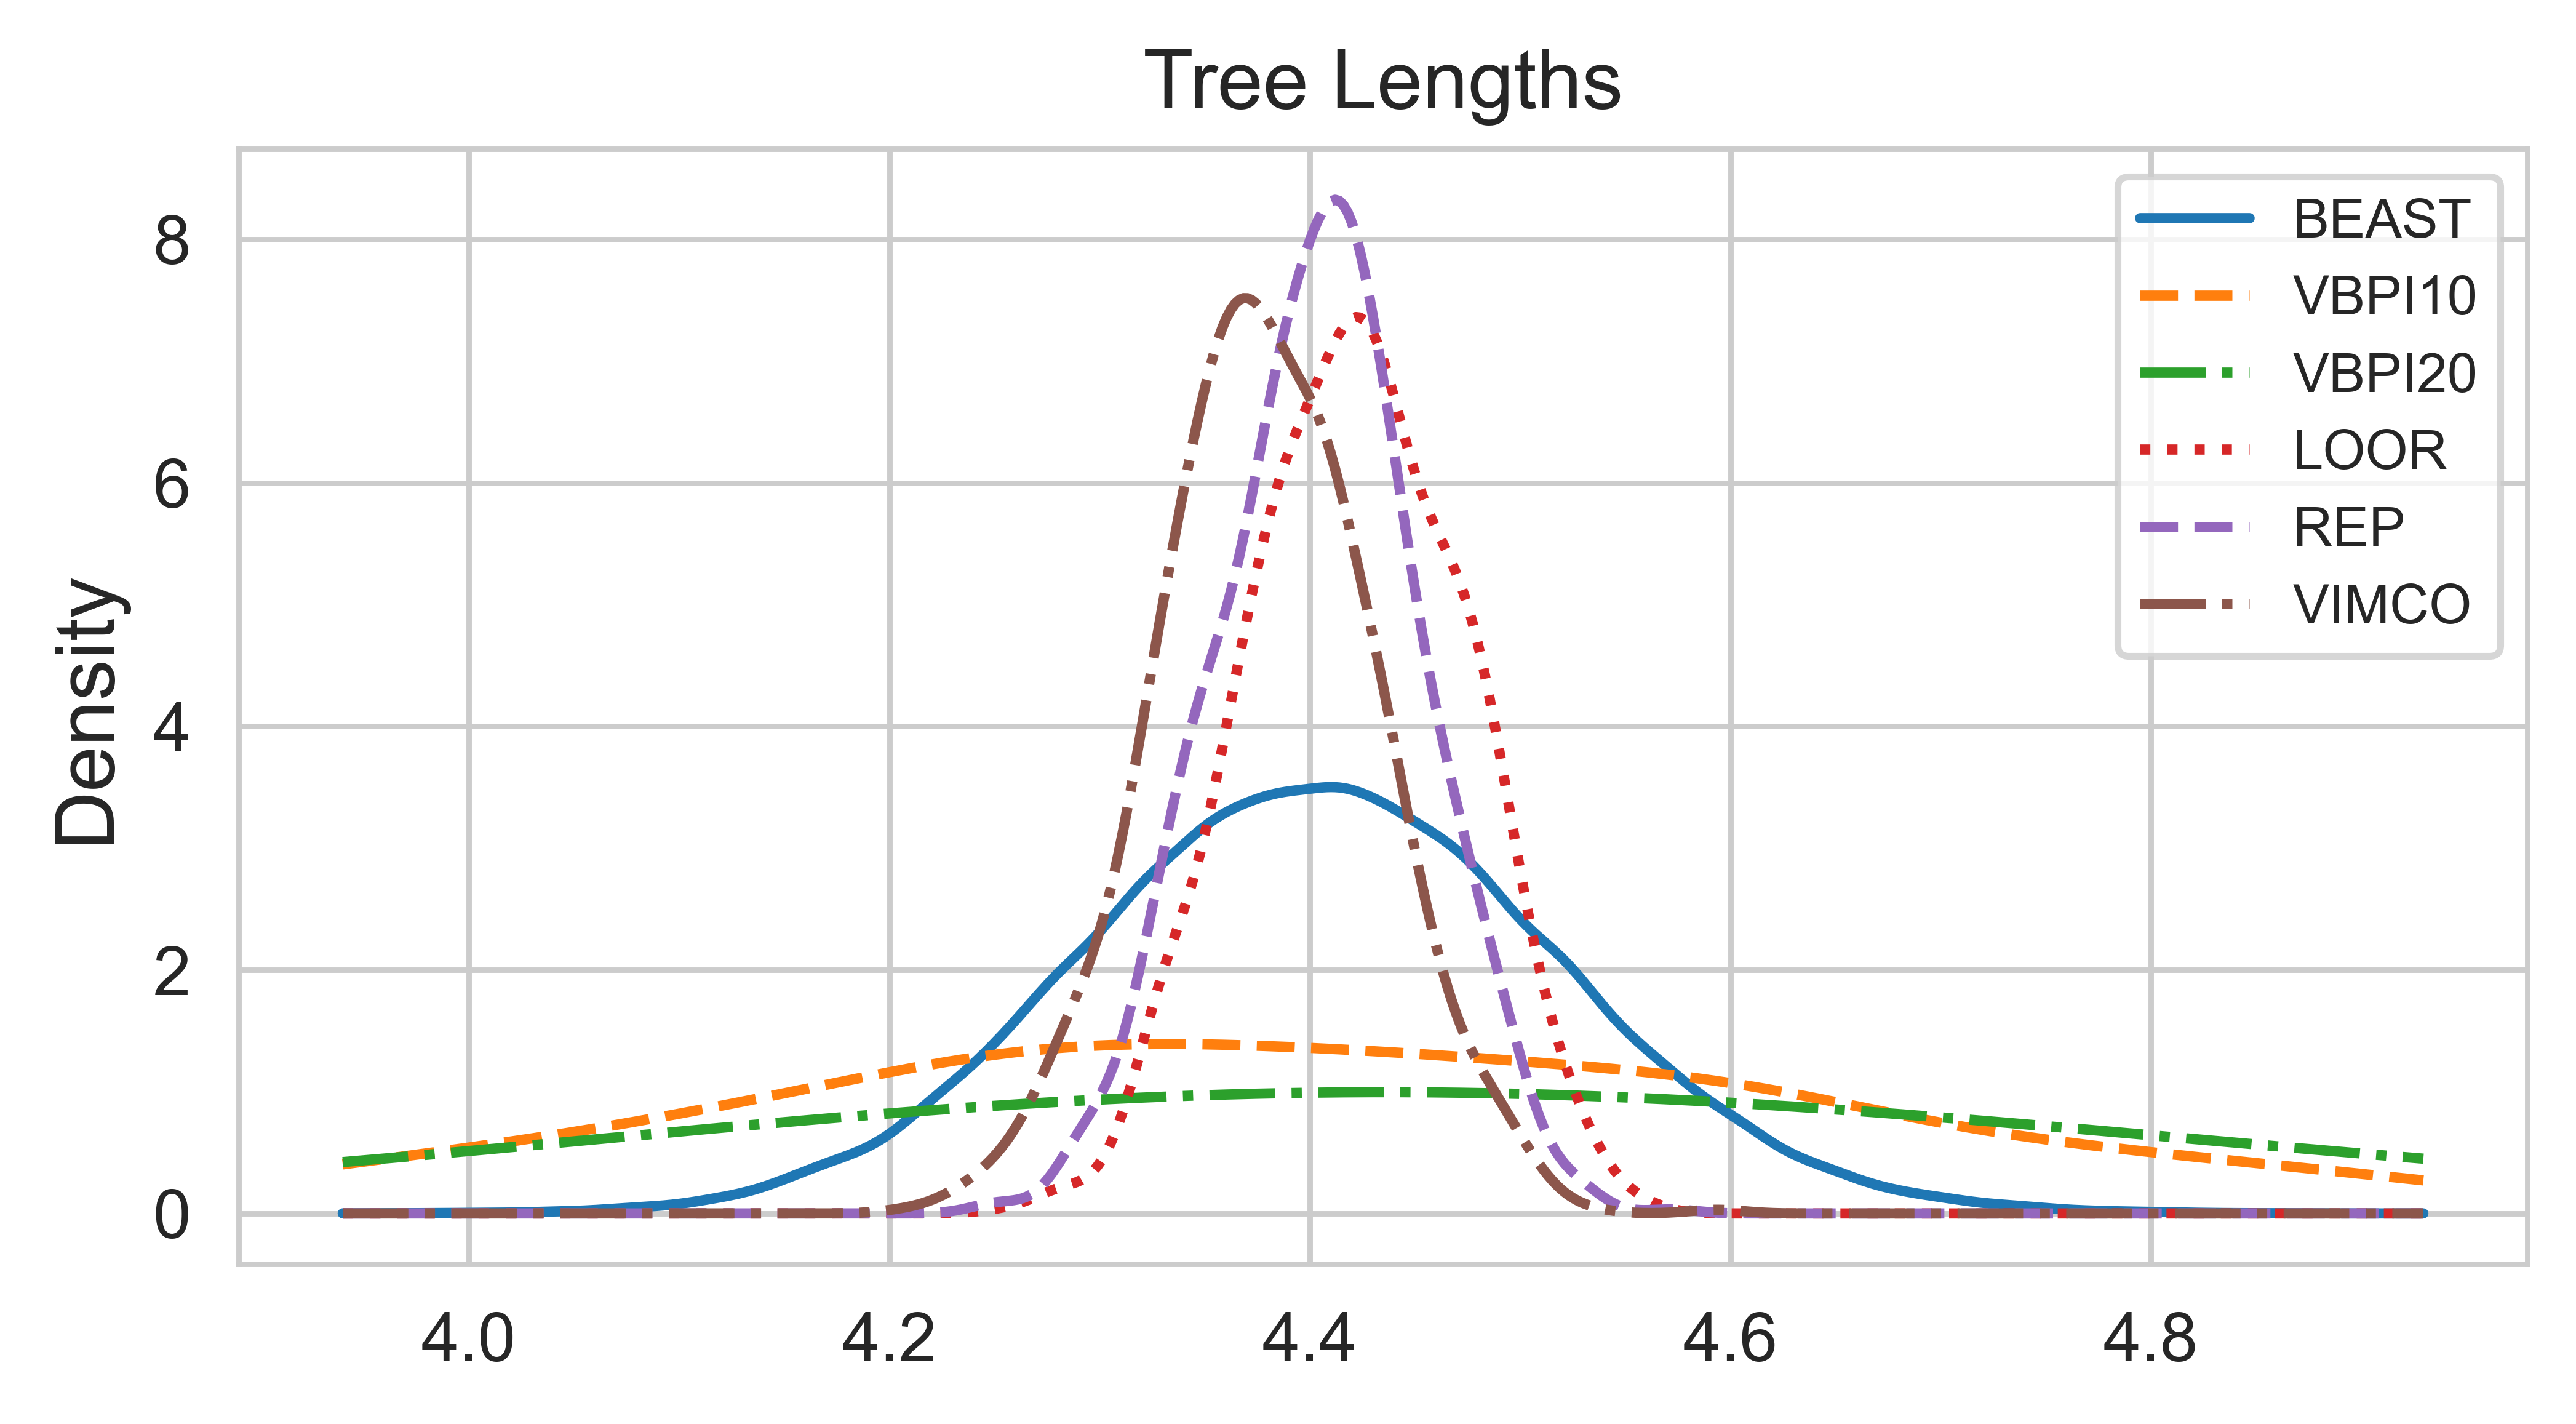

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi = 800)

### ELBO over time ###

plt.clf()
plt.subplot(1,1,1)


def plot_histogram(data,title):

    
    if data_set == "DS1":
        bins = np.linspace(start=0.36, stop=0.48, num=500)
    elif data_set == "DS14":
        bins = np.linspace(start=0.12, stop=0.22, num=500)
    else:
        mini = min([min(data["BEAST"]) for key in data])
        maxi = max([max(data["BEAST"]) for key in data])
        bins = np.linspace(start=mini, stop=maxi, num=500)
    
    density = gaussian_kde(data["BEAST"])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle=linestyles["BEAST"], color=colors["BEAST"])

    for model in models:
        density = gaussian_kde(data[model])
        density_vals = density(bins)
        plt.plot(bins, density_vals, linestyle=linestyles[model], color=colors[model])

    plt.legend(["BEAST"]+["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
    plt.title(title)
    plt.ylabel("Density",fontsize = 12)
    if data_set == "DS1":
        plt.xlim([0.36,0.48])
        plt.ylim([0, 70])
    elif data_set == "DS14":
        plt.xlim([0.12,0.22])
        plt.ylim([0,140])
    return


plt.subplot(1,1,1)
data = {k: tree_lengths[k] for k in ["BEAST"]+models}
title = "Tree Lengths"
plot_histogram(data,title)

#plt.subplot(2,2,2)
#data = {k: log_likes[k] for k in ["BEAST"]+models}
#title = "Tree Log-likelihood"
#plot_histogram(data,title)

#plt.tight_layout()
plt.savefig('../plt/'+data_set+'/F2A.png')
plt.show()

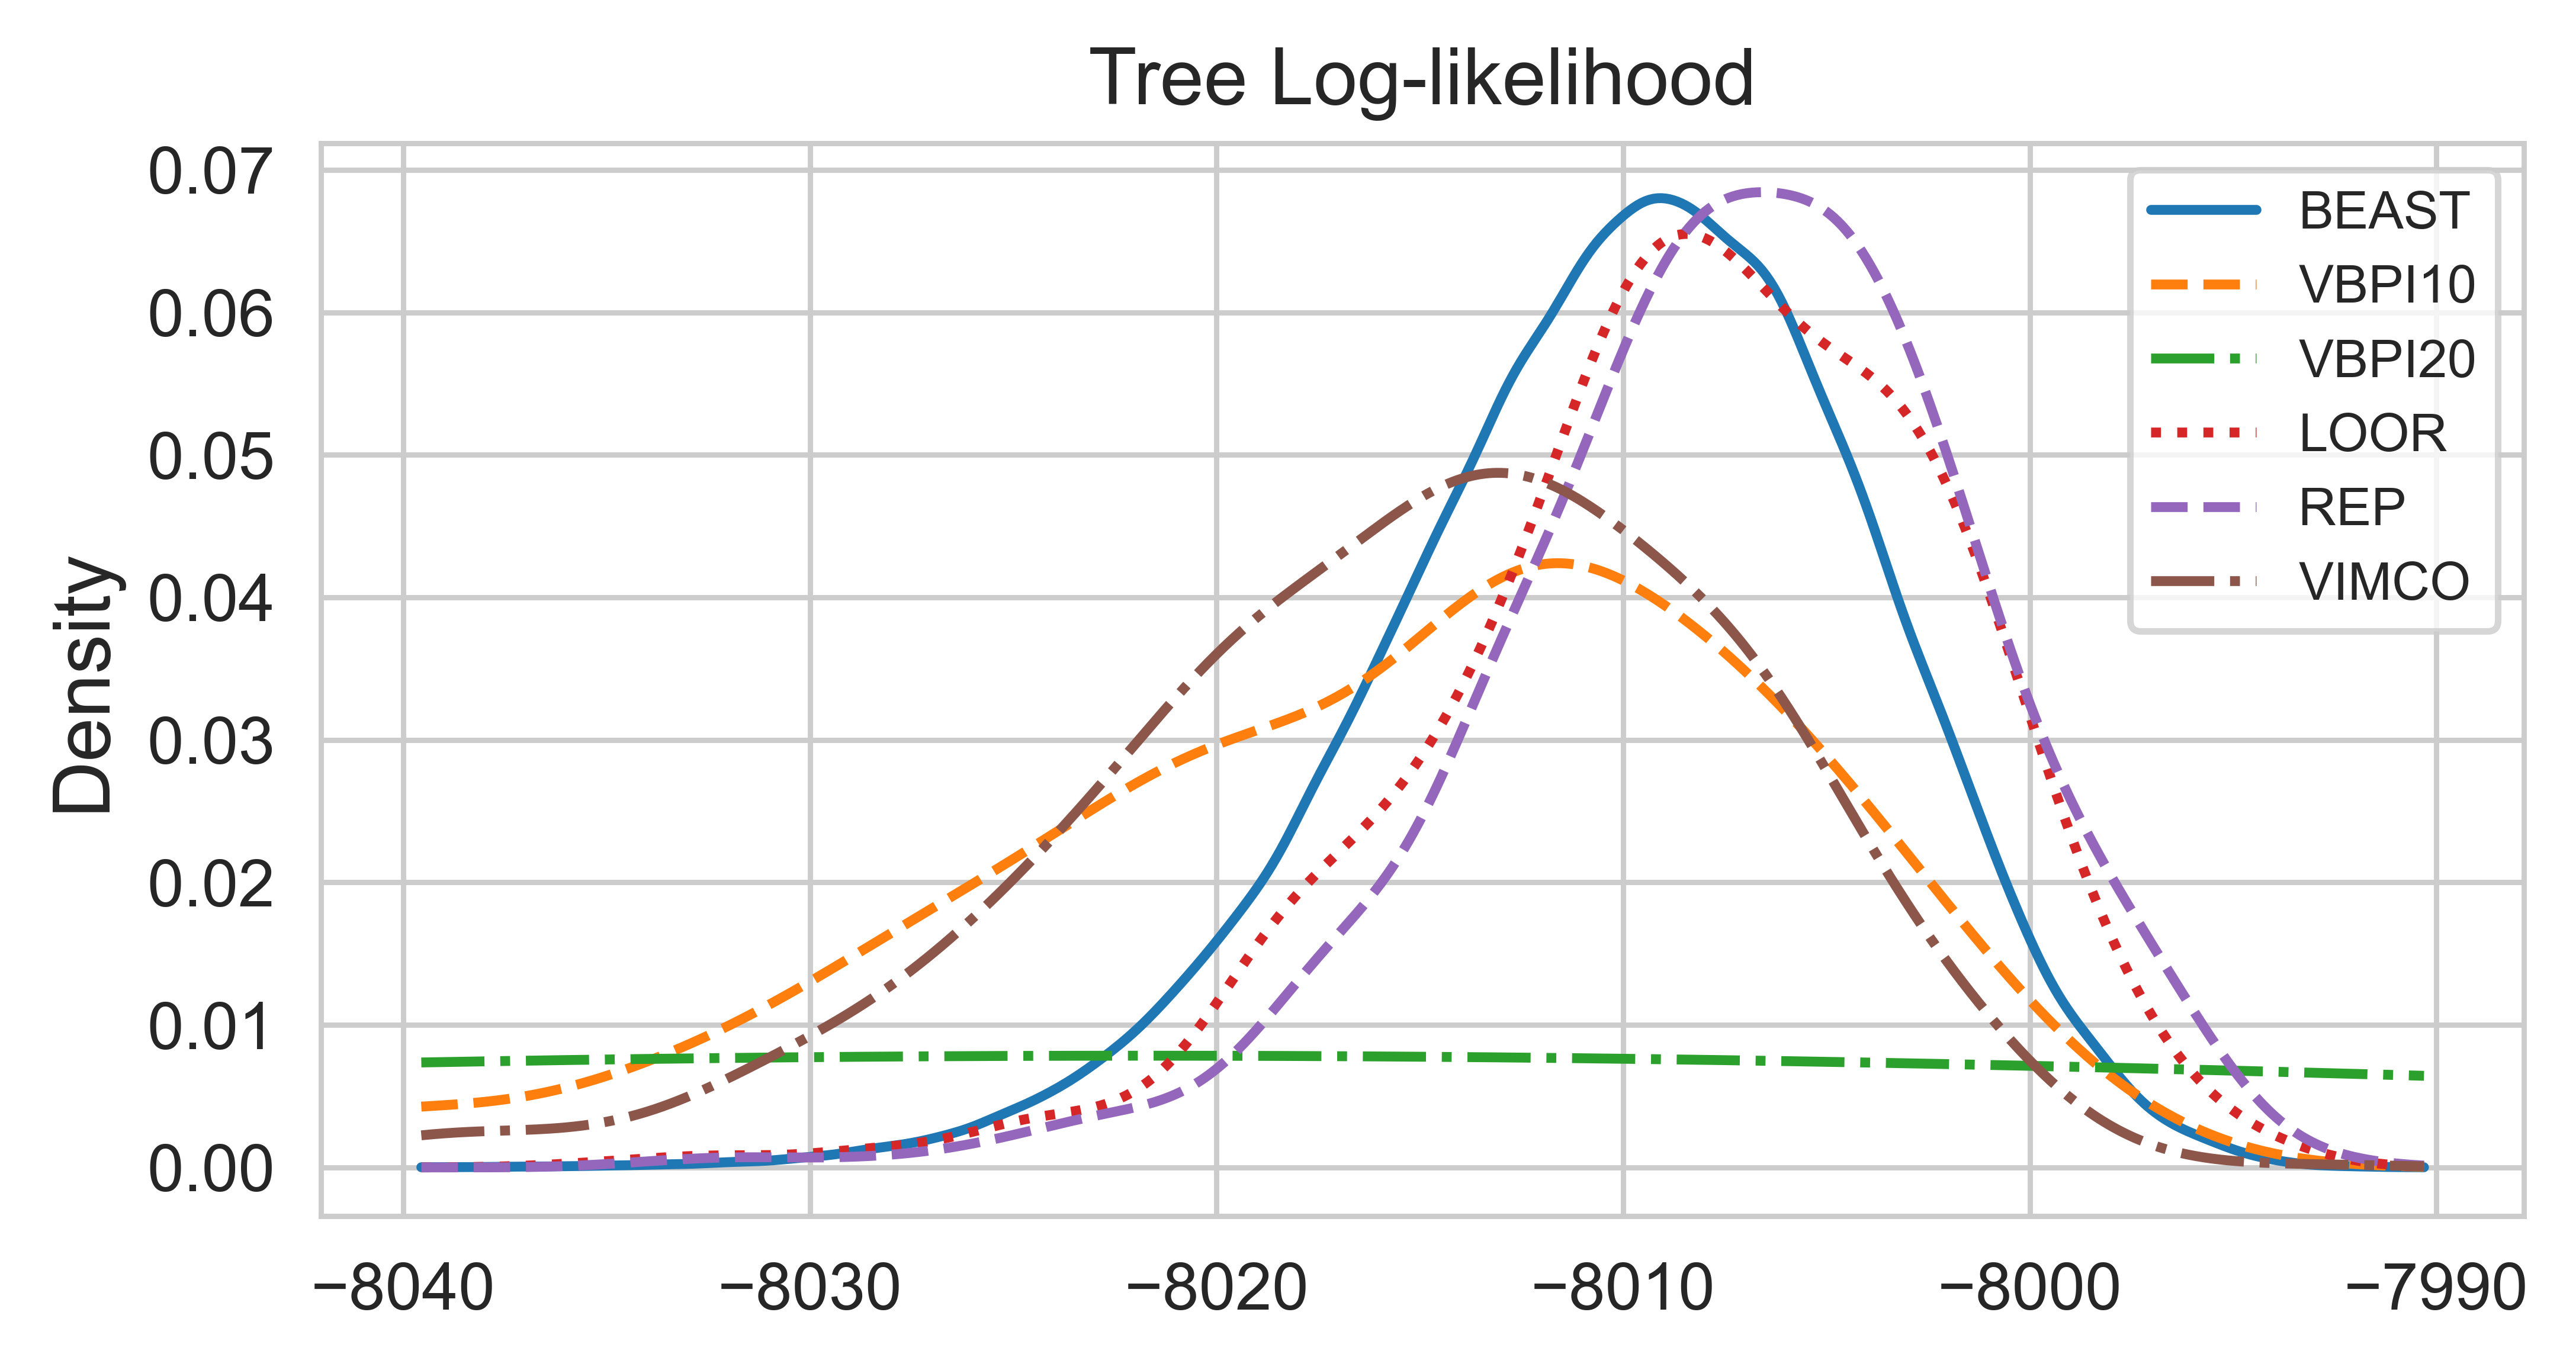

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi = 800)

### ELBO over time ###

plt.clf()
plt.subplot(1,1,1)


def plot_histogram(data,title):
    #_, bins, _ = plt.hist(data["BEAST"], bins = 100, edgecolor='black', alpha = 0.25, 
    #                  density=True, color=colors["BEAST"])
    
    if data_set == "DS1":
        bins = np.linspace(start=-7000, stop=-6960, num=500)
    elif data_set == "DS14":
        bins = np.linspace(start=-8000, stop=-7000, num=500)
    else:
        mini = min([min(data["BEAST"]) for key in data])
        maxi = max([max(data["BEAST"]) for key in data])
        bins = np.linspace(start=mini, stop=maxi, num=500)
    
    density = gaussian_kde(data["BEAST"])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle=linestyles["BEAST"], color=colors["BEAST"])

    for model in models:
        density = gaussian_kde(data[model])
        density_vals = density(bins)
        plt.plot(bins, density_vals, linestyle=linestyles[model], color=colors[model])

    plt.legend(["BEAST"]+["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
    plt.title(title)
    plt.ylabel("Density",fontsize = 12)
    
    if data_set == "DS1":
        plt.xlim([-7000,-6960])
        plt.ylim([0,0.12])
    elif data_set == "DS14":
        plt.xlim([-8000,-7000])
        plt.ylim([0,0.05])        
    return


plt.subplot(1,1,1)
#data = {k: tree_lengths[k] for k in ["BEAST"]+models}
#title = "Tree Lengths"
#plot_histogram(data,title)

#plt.subplot(2,2,2)
data = {k: log_likes[k] for k in ["BEAST"]+models}
title = "Tree Log-likelihood"
plot_histogram(data,title)

#plt.tight_layout()
plt.savefig('../plt/'+data_set+'/F2B.png')
plt.show()

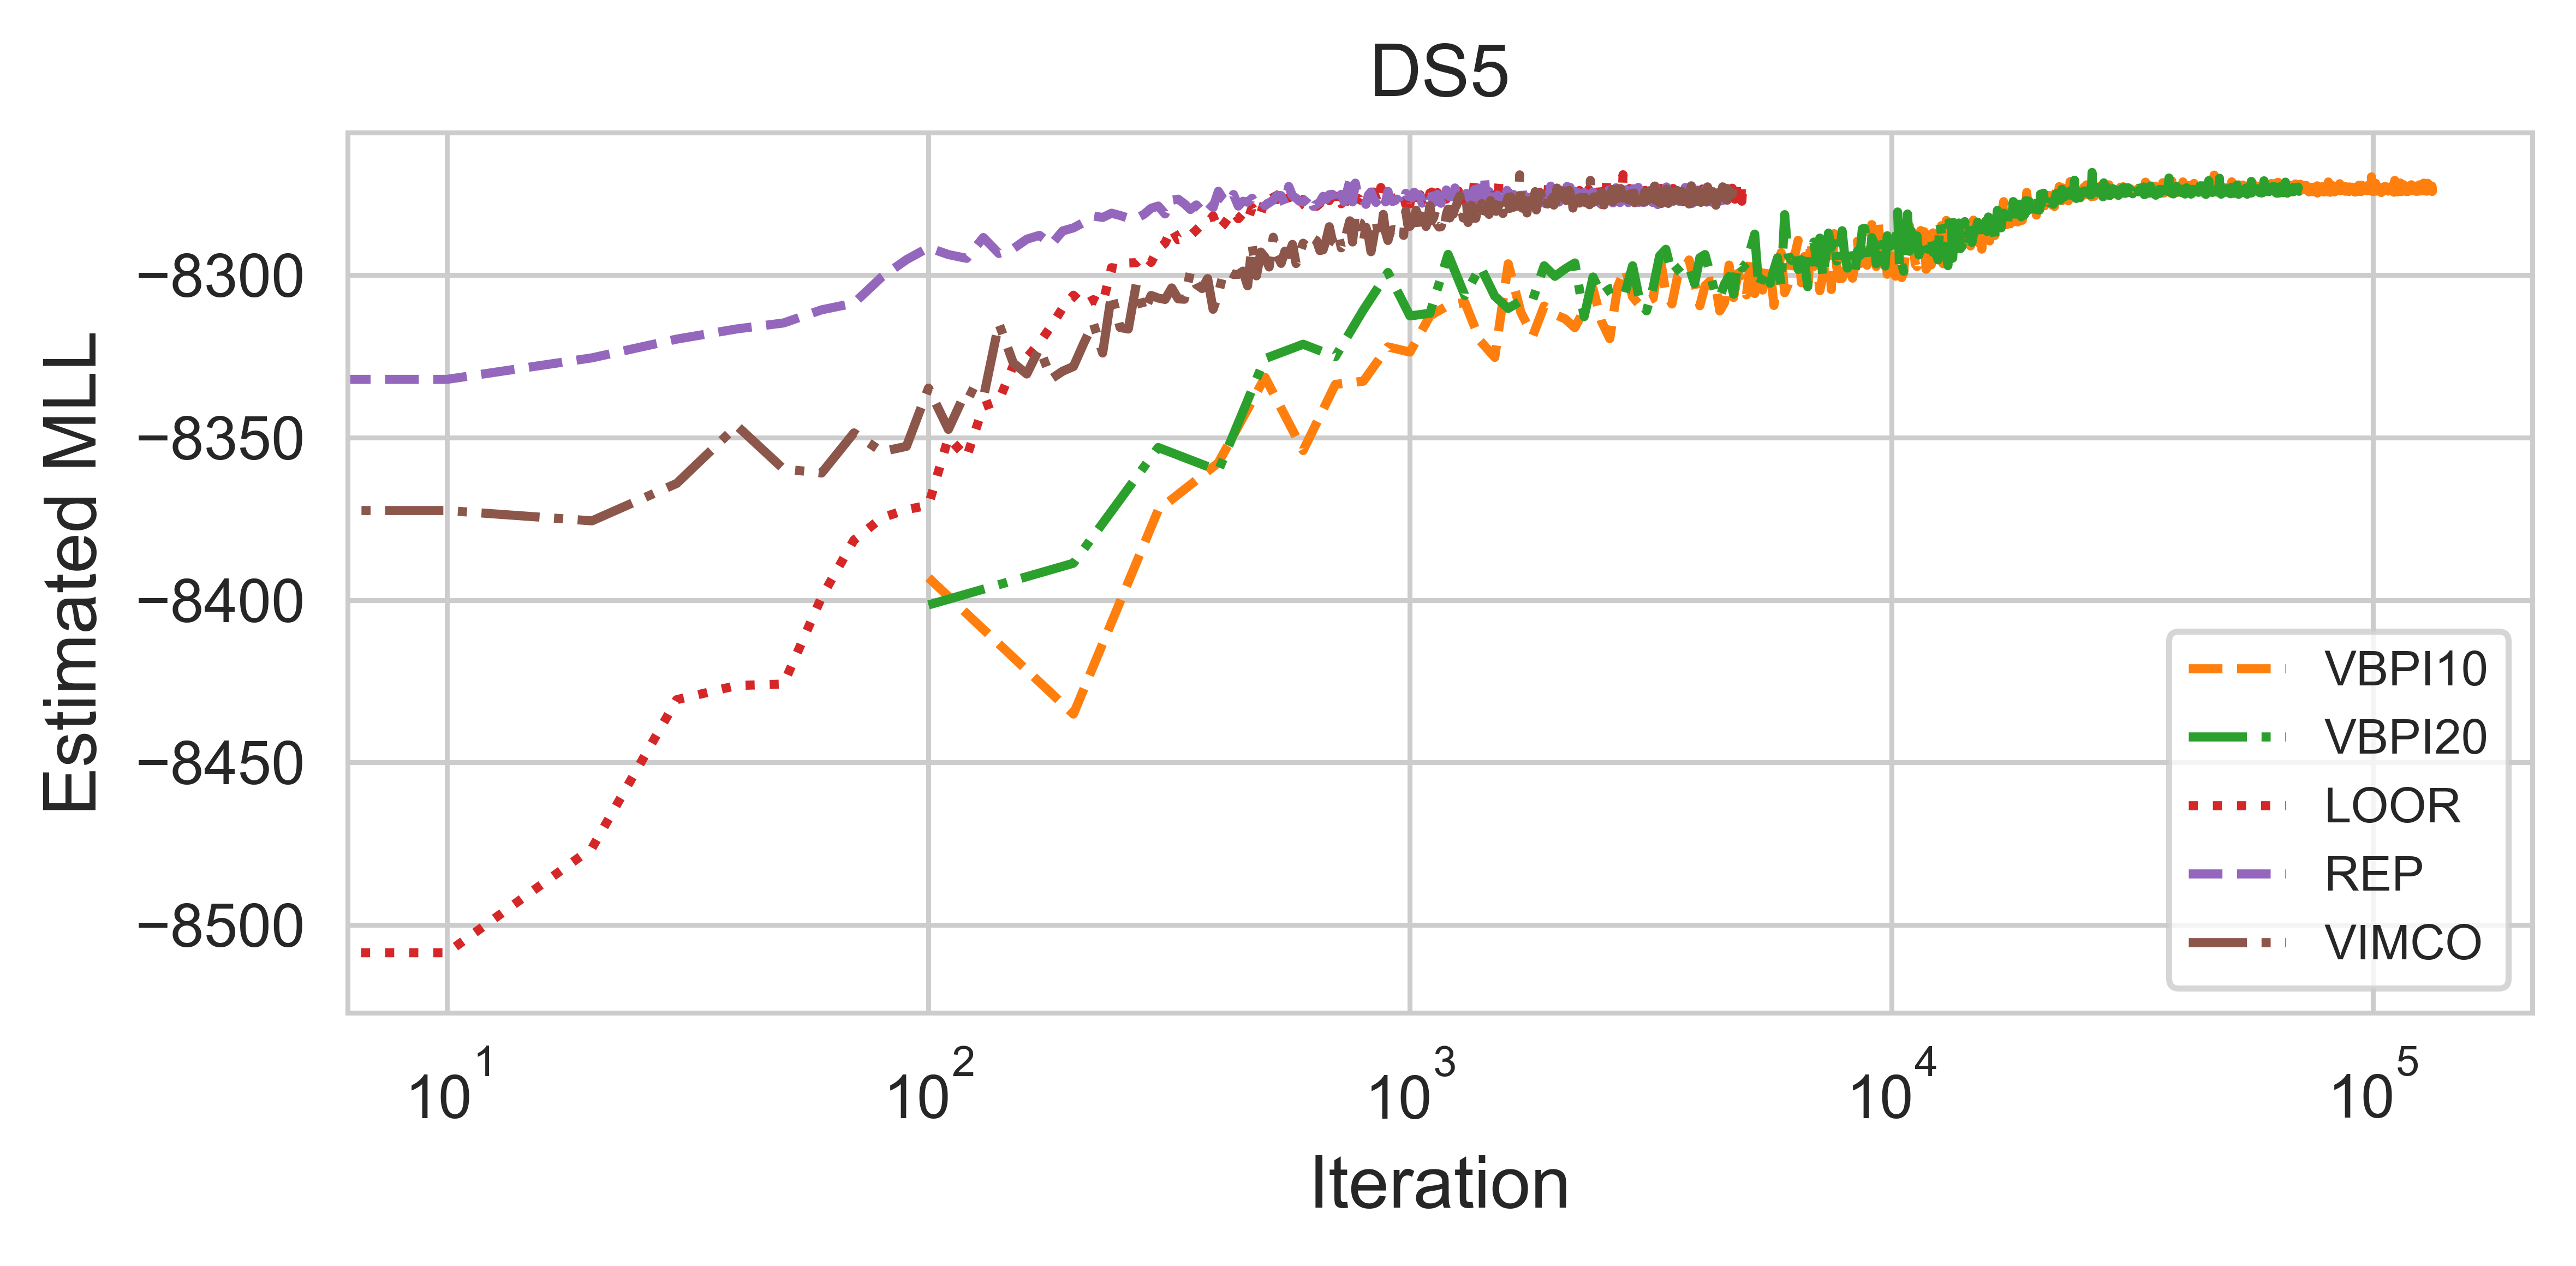

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi = 800)

### ELBO over time ###

plt.subplot(1,1,1)
plt.clf()

for model in models:
    plt.plot(iters[model],
             MLLs[model],
             color = colors[model], linestyle=linestyles[model])

#plt.ylim(ELBO_min-5,ELBO_max+10)
plt.ylabel("Estimated MLL",fontsize = 12)

plt.title(data_set)

plt.xscale('log')
plt.xlabel("Iteration",fontsize = 12)

plt.legend(["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
if data_set == "DS1":
    plt.xlim([10**0.5, 10**(5.5)])
    plt.ylim([-7300, -7125-12.5])
elif data_set == "DS14":
    plt.xlim([10**0.5, 10**(5.5)])
    plt.ylim([-11500, -7500])
else:
    pass
# Set inset limits and labels
#axins.set_xlim(zoom_region)
#axins.set_xscale('log')
#axins.set_xticklabels([])
#axins.set_ylim([ELBO_max-10,ELBO_max+10])

plt.tight_layout()
plt.savefig('../plt/'+data_set+'/F2C.png')
plt.show()

In [14]:
# get bootstrap standard error of our models
def get_MLLs(log_p_minus_log_q):
    return logsumexp(log_p_minus_log_q) - np.log(len(log_p_minus_log_q))

def MLL_se(p_qs):
    
    MLL_hats = []
    
    for _ in range(100):
        boot_sample = np.random.choice(p_qs,size=len(p_qs),replace=True)
        boot_MLL = logsumexp(boot_sample) - np.log(len(boot_sample))
        MLL_hats.append(boot_MLL)
        
    return np.std(MLL_hats,ddof=1)


def ELBO_se(p_qs):
    
    ELBO_hats = []
    
    for _ in range(100):
        boot_sample = np.random.choice(p_qs,size=len(p_qs),replace=True)
        boot_ELBO = np.mean(boot_sample)
        ELBO_hats.append(boot_ELBO)
        
    return np.std(ELBO_hats,ddof=1)

In [15]:
data = {'model': ["BEAST"] + models, 
        'MLL': [np.mean(BEAST_MLLs)] + [get_MLLs(log_p_minus_log_q[key]) for key in log_p_minus_log_q],
        'MLL_se': [np.std(BEAST_MLLs,ddof=1)] + [MLL_se(log_p_minus_log_q[key]) for key in log_p_minus_log_q],
        'ELBO': [np.nan] + [np.mean(log_p_minus_log_q[key]) for key in log_p_minus_log_q],
        'ELBO_se': [np.nan] + [ELBO_se(log_p_minus_log_q[key]) for key in log_p_minus_log_q]}
df = pd.DataFrame(data)

print(data_set)

print("MLLs:")
print("")
print("BEAST: %.2f(%.2f)"%(data['MLL'][0],data['MLL_se'][0]))
MLL_line = "%.2f(%.2f)"%(data['MLL'][0],data['MLL_se'][0])
for i,key in enumerate(log_p_minus_log_q):
    print("%s: %.2f(%.2f)"%(key,data['MLL'][i+1]-data['MLL'][0],data['MLL_se'][i+1]))
    MLL_line += " & %.2f(%.2f)"%(data['MLL'][i+1]-data['MLL'][0],data['MLL_se'][i+1])
    
MLL_line += " \\\\"

print("")
print("ELBO:")
print("")
ELBO_line = ""
for i,key in enumerate(log_p_minus_log_q):
    print("%s: %.2f(%.2f)"%(key,data['ELBO'][i+1],data['ELBO_se'][i+1]))
    ELBO_line += "%.2f(%.2f)  & "%(data['ELBO'][i+1],data['ELBO_se'][i+1])

ELBO_line += " \\\\"

print(MLL_line)
print(ELBO_line)
# Save the DataFrame to a CSV file
df.to_csv('plt/'+data_set+'_MLLs.csv', index=False)

plt.scatter(data["model"],data["MLL"],c=[colors[key] for key in colors],s=500)
plt.ylabel("Estimated MLL (100 samples)")
plt.savefig('../plt/'+data_set+'/MLLs.png')
plt.show()

plt.scatter(data["model"],data["ELBO"],c=[colors[key] for key in colors],s=500)
plt.ylabel("Estimated ELBO (100 samples)")
plt.savefig('../plt/'+data_set+'/ELBOs.png')

DS5
MLLs:

BEAST: -8271.26(0.39)
VBPI_10: -1.70(0.35)
VBPI_20: -5.69(0.51)
reinforce: -0.29(1.85)
reparam: -4.01(0.30)
VIMCO: 0.94(2.17)

ELBO:

VBPI_10: -8281.03(0.23)
VBPI_20: -8298.64(5.44)
reinforce: -8279.93(0.12)
reparam: -8280.35(0.10)
VIMCO: -8282.03(0.19)
-8271.26(0.39) & -1.70(0.35) & -5.69(0.51) & -0.29(1.85) & -4.01(0.30) & 0.94(2.17) \\
-8281.03(0.23)  & -8298.64(5.44)  & -8279.93(0.12)  & -8280.35(0.10)  & -8282.03(0.19)  &  \\


OSError: Cannot save file into a non-existent directory: 'plt'